In [ ]:
import collections
import math
import os
import random
import torch
from torch import nn
from d2l import torch as d2l

# 15.1. Word Embedding (word2vec)

- skip-gram model
    - assumes that a word can be used to generate its surrounding words in a text sequence
    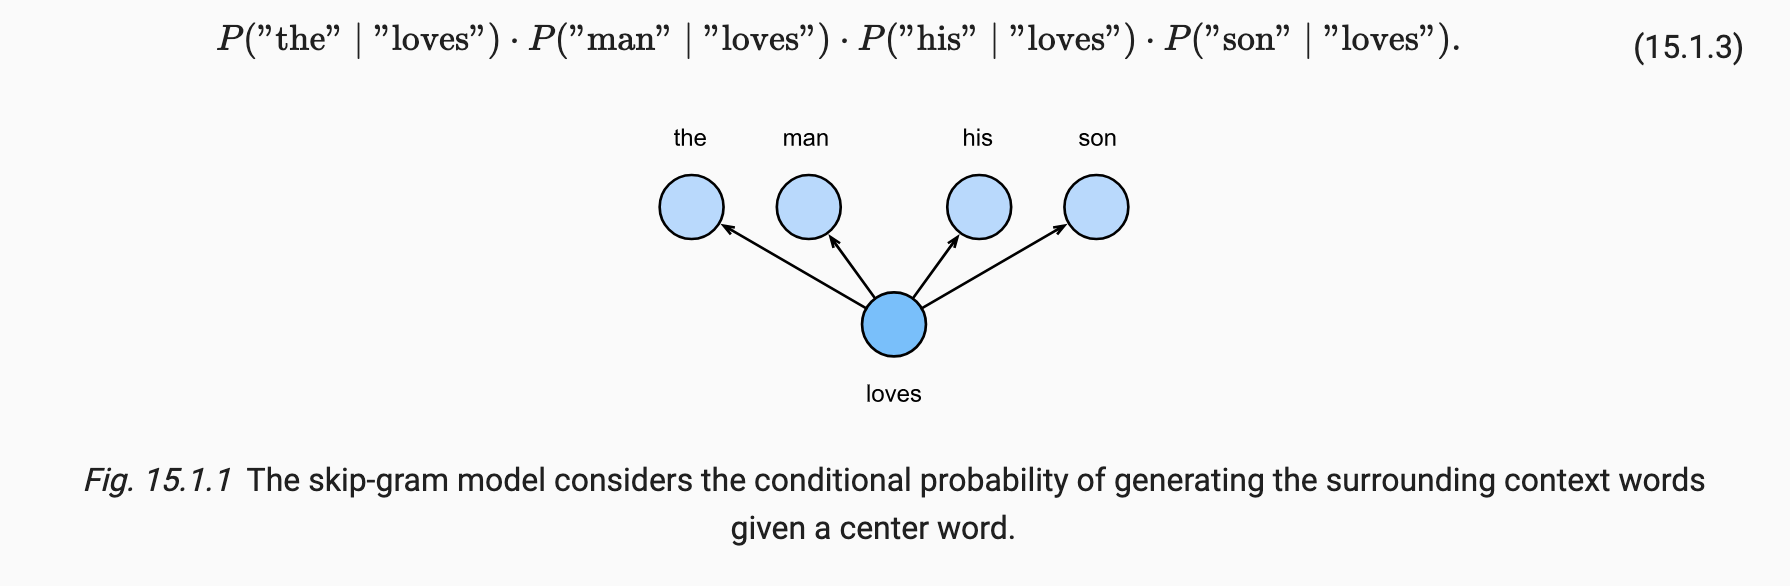
    - for any word with index i in the dictionary, denote by $\mathbf{v}_i\in\mathbb{R}^d$ and $\mathbf{u}_i\in\mathbb{R}^d$ its two vectors when used as a center word and a context word, respectively
    - The conditional probability of generating any context word $w_o$ (with index o in the dictionary) given the center word $w_c$ (with index c in the dictionary) can be modeled by a softmax operation on vector dot products:
    $$P(w_o \mid w_c) = \frac{\exp(\mathbf{u}_o^\top \mathbf{v}_c)}{ \sum_{i \in \mathcal{V}} \exp(\mathbf{u}_i^\top \mathbf{v}_c)}$$
    where the vocabulary index set $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$
    - For context window size m, the likelihood function of the skip-gram model is the probability of generating all context words given any center word:
    $$\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$
    where any time step that is less than 1 or greater than T can be omitted.
    - max likelihood function is equivalent to minimizing the following loss function:
    $$- \sum_{t=1}^{T} \sum_{-m \leq j \leq m,\ j \neq 0} \textrm{log}\, P(w^{(t+j)} \mid w^{(t)}).$$
- Continuous Bag of Words (CBOW) Model
    - The major difference from the skip-gram model is that the continuous bag of words model assumes that a center word is generated based on its surrounding context words in the text sequence.
    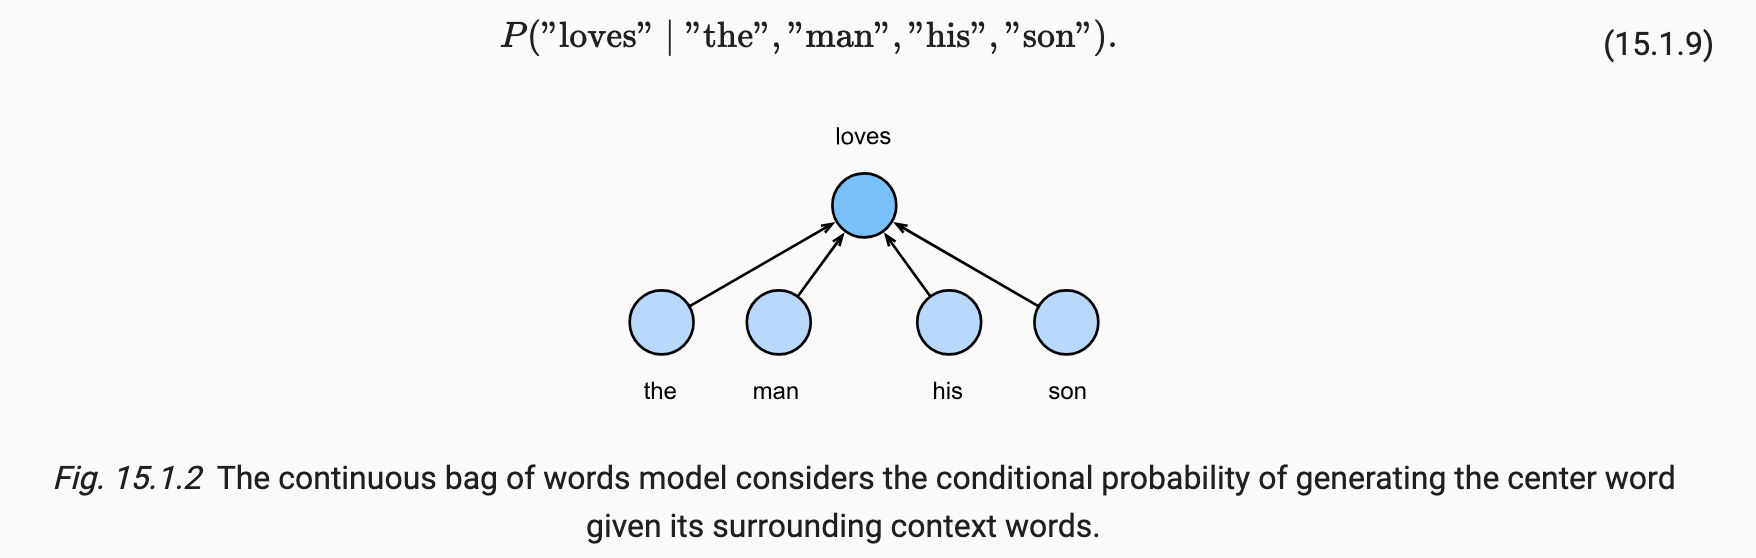
    - The conditional probability of generating any center word $w_c$ (with index c in the dictionary) given its surrounding context words $w_{o_1}, \ldots, w_{o_{2m}}$ (with index $o_1, \ldots, o_{2m}$ in the dictionary) can be modeled by
    $$P(w_c \mid w_{o_1}, \ldots, w_{o_{2m}}) = \frac{\exp\left(\frac{1}{2m}\mathbf{u}_c^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}{ \sum_{i \in \mathcal{V}} \exp\left(\frac{1}{2m}\mathbf{u}_i^\top (\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}}) \right)}.$$
    $$P(w_c \mid \mathcal{W}_o) = \frac{\exp\left(\mathbf{u}_c^\top \bar{\mathbf{v}}_o\right)}{\sum_{i \in \mathcal{V}} \exp\left(\mathbf{u}_i^\top \bar{\mathbf{v}}_o\right)}.$$  
    where $\mathcal{W}_o= \{w_{o_1}, \ldots, w_{o_{2m}}\}$ and $\bar{\mathbf{v}}_o = \left(\mathbf{v}_{o_1} + \ldots + \mathbf{v}_{o_{2m}} \right)/(2m)$
    - Given a text sequence of length T, where the word at time step t is denoted as $w^{(t)}$. For context window size m, the likelihood function of the continuous bag of words model is the probability of generating all center words given their context words:
    $$\prod_{t=1}^{T}  P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$
    - The maximum likelihood estimation of the continuous bag of words model is equivalent to minimizing the following loss function:
    $$-\sum_{t=1}^T  \textrm{log}\, P(w^{(t)} \mid  w^{(t-m)}, \ldots, w^{(t-1)}, w^{(t+1)}, \ldots, w^{(t+m)}).$$

# 15.2. Approximate Training

- the computational cost for skip-gram and CBOW gradients that sum over a large dictionary (often with hundreds of thousands or millions of words) is huge!
- negative sampling
    - Negative sampling modifies the original objective function. Given the context window of a center word $w_c$, the fact that any (context) word $W_o$ comes from this context window is considered as an event with the probability modeled by
    $$P(D=1\mid w_c, w_o) = \sigma(\mathbf{u}_o^\top \mathbf{v}_c),$$
    where $\sigma$ uses the definition of the sigmoid activation function:
    $$\sigma(x) = \frac{1}{1+\exp(-x)}.$$
    - given a text sequence of length T, denote by $w^{(t)}$ the word at time step t and let the context window size be m, consider maximizing the joint probability
    $$\prod_{t=1}^{T} \prod_{-m \leq j \leq m,\ j \neq 0} P(w^{(t+j)} \mid w^{(t)}),$$
    $$P(w^{(t+j)} \mid w^{(t)}) =P(D=1\mid w^{(t)}, w^{(t+j)})\prod_{k=1,\ w_k \sim P(w)}^K P(D=0\mid w^{(t)}, w_k).$$
- hierarchical softmax
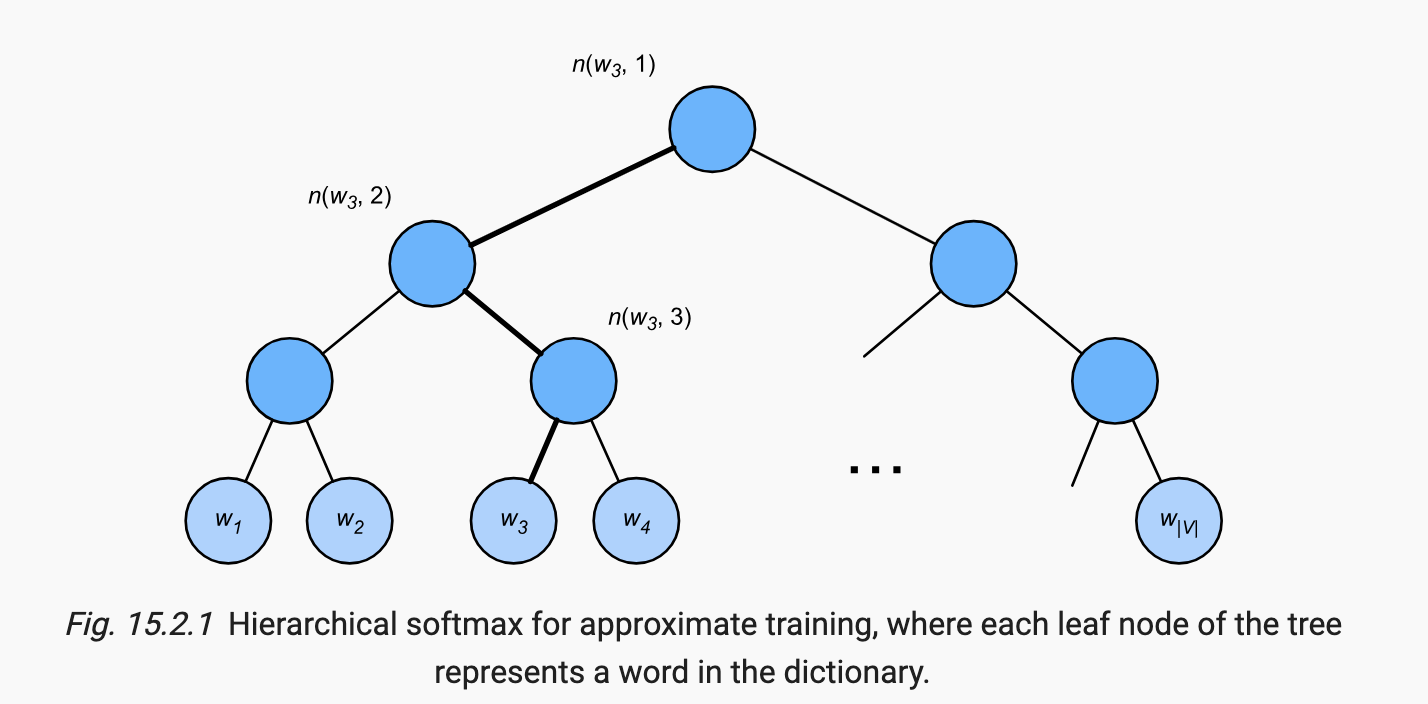
    - Denote by $L(w)$ the number of nodes (including both ends) on the path from the root node to the leaf node representing word w in the binary tree. Let $n(w,j)$ be the $j^\textrm{th}$ node on this path, with its context word vector being $\mathbf{u}_{n(w, j)}$. Hierarchical softmax approximates the conditional probability as
    $$P(w_o \mid w_c) = \prod_{j=1}^{L(w_o)-1} \sigma\left( [\![  n(w_o, j+1) = \textrm{leftChild}(n(w_o, j)) ]\!] \cdot \mathbf{u}_{n(w_o, j)}^\top \mathbf{v}_c\right),$$
    where function $\sigma$ is defined in (15.2.2), and $\textrm{leftChild}(n)$ is the left child node of node n: if x is true, $[\![x]\!] = 1$; otherwise $[\![x]\!] = -1$
.


# 15.3. The Dataset for Pretraining Word Embeddings

## 15.3.1. Reading the Dataset

In [2]:
# @save
d2l.DATA_HUB["ptb"] = (
    d2l.DATA_URL + "ptb.zip",
    "319d85e578af0cdc590547f26231e4e31cdf1e42",
)


# @save
def read_ptb():
    """Load the PTB dataset into a list of text lines."""
    data_dir = d2l.download_extract("ptb")
    # Read the training set
    with open(os.path.join(data_dir, "ptb.train.txt")) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split("\n")]


sentences = read_ptb()
f"# sentences: {len(sentences)}"

'# sentences: 42069'

In [19]:
# any word that appears less than 10 times is replaced by the “<unk>” token
vocab = d2l.Vocab(sentences, min_freq=10)
f"vocab size: {len(vocab)}"

'vocab size: 6719'

## 15.3.2. Subsampling

high-frequency words can be subsampled  
each indexed word $w_i$ in the dataset will be discarded with probability
$$P(w_i) = \max\left(1 - \sqrt{\frac{t}{f(w_i)}}, 0\right),$$ 
where $f(w_i)$ is the ratio of the number of words $w_i$ to the total number of words in the dataset, and the constant t is a hyperparameter ($10^{-4}$ in the experiment).

In [4]:
# @save
def subsample(sentences, vocab):
    """Subsample high-frequency words."""
    # Exclude unknown tokens ('<unk>')
    sentences = [
        [token for token in line if vocab[token] != vocab.unk] for line in sentences
    ]
    counter = collections.Counter([token for line in sentences for token in line])
    num_tokens = sum(counter.values())

    # Return True if `token` is kept during subsampling
    def keep(token):
        return random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens)

    return ([[token for token in line if keep(token)] for line in sentences], counter)


subsampled, counter = subsample(sentences, vocab)

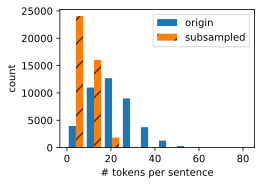

In [20]:
# subsampling significantly shortens sentences by dropping high-frequency words, which will lead to training speedup.
d2l.show_list_len_pair_hist(
    ["origin", "subsampled"], "# tokens per sentence", "count", sentences, subsampled
)

In [6]:
def compare_counts(token):
    return (
        f'# of "{token}": '
        f"before={sum([l.count(token) for l in sentences])}, "
        f"after={sum([l.count(token) for l in subsampled])}"
    )


compare_counts("the")

'# of "the": before=50770, after=2079'

In [7]:
compare_counts("join")

'# of "join": before=45, after=45'

In [ ]:
# map tokens to their indices for the corpus
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [4127, 3228, 1773, 4060], [3922, 1922, 4743]]

## 15.3.3. Extracting Center Words and Context Words

In [21]:
# The following get_centers_and_contexts function extracts all the center words and their context words from corpus
# @save
def get_centers_and_contexts(corpus, max_window_size):
    """Return center words and context words in skip-gram."""
    centers, contexts = [], []
    for line in corpus:
        # To form a "center word--context word" pair, each sentence needs to
        # have at least 2 words
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at `i`
            window_size = random.randint(1, max_window_size)
            indices = list(
                range(max(0, i - window_size), min(len(line), i + 1 + window_size))
            )
            # Exclude the center word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

In [10]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print("dataset", tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print("center", center, "has contexts", context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [1, 2, 4, 5]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


In [11]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f"# center-context pairs: {sum([len(contexts) for contexts in all_contexts])}"

'# center-context pairs: 1503520'

## 15.3.4. Negative Sampling

In [12]:
# @save
class RandomGenerator:
    """Randomly draw among {1, ..., n} according to n sampling weights."""

    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # Cache `k` random sampling results
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000
            )
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

draw 10 random variables X among indices 1, 2, and 3 with sampling probabilities $P(X=1)=2/9, P(X=2)=3/9$, and $P(X=3)=4/9$ as follows.

In [13]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 2, 3, 1, 3, 2, 3, 3, 3]

In [22]:
# For a pair of center word and context word, we randomly sample K (5 in the experiment) noise words
# the sampling probability P(w) of a noise word w is set to its relative frequency in the dictionary raised to the power of 0.75
# @save
def get_negatives(all_contexts, vocab, counter, K):
    """Return noise words in negative sampling."""
    # Sampling weights for words with indices 1, 2, ... (index 0 is the
    # excluded unknown token) in the vocabulary
    sampling_weights = [
        counter[vocab.to_tokens(i)] ** 0.75 for i in range(1, len(vocab))
    ]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 15.3.5. Loading Training Examples in Minibatches

- In a minibatch, the $i^\textrm{th}$ example includes a center word and its $n_i$ context words and $m_i$ noise words.
- for each example we concatenate its context words and noise words in the contexts_negatives variable, and pad zeros until the concatenation length reaches $\max_i n_i+m_i$ (max_len). 
- To exclude paddings in the calculation of the loss, we define a mask variable masks. There is a one-to-one correspondence between elements in masks and elements in contexts_negatives, where zeros (otherwise ones) in masks correspond to paddings in contexts_negatives.
- we separate context words from noise words in contexts_negatives via a labels variable. Similar to masks, there is also a one-to-one correspondence between elements in labels and elements in contexts_negatives, where ones (otherwise zeros) in labels correspond to context words (positive examples) in contexts_negatives.

In [23]:
# Its input data is a list with length equal to the batch size, where each element is an example consisting of the center word center, its context words context, and its noise words negative.
# @save
def batchify(data):
    """Return a minibatch of examples for skip-gram with negative sampling."""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (
        torch.tensor(centers).reshape((-1, 1)),
        torch.tensor(contexts_negatives),
        torch.tensor(masks),
        torch.tensor(labels),
    )

In [16]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ["centers", "contexts_negatives", "masks", "labels"]
for name, data in zip(names, batch):
    print(name, "=", data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


## 15.3.6. Putting It All Together

In [17]:
# @save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """Download the PTB dataset and then load it into memory."""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index], self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True, collate_fn=batchify, num_workers=num_workers
    )
    return data_iter, vocab

In [18]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, "shape:", data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# 15.4. Pretraining word2vec

In [25]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

## 15.4.1. The Skip-Gram Model

In [ ]:
# an embedding layer maps a token’s index to its feature vector
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(
    f"Parameter embedding_weight ({embed.weight.shape}, " f"dtype={embed.weight.dtype})"
)

Parameter embedding_weight (torch.Size([20, 4]), dtype=torch.float32)


In [27]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[-0.8619, -0.6403,  0.7910,  0.6949],
         [-1.0059, -0.5464,  0.1899, -0.9445],
         [-0.5342, -0.9080,  0.2384, -0.8051]],

        [[-0.8042, -0.5200,  1.1436, -0.2670],
         [ 0.5030,  1.0443, -0.3647, -0.6633],
         [-1.6600,  0.4670, -1.3050, -0.0958]]], grad_fn=<EmbeddingBackward0>)

the input of the skip-gram model includes the center word indices center of shape (batch size, 1) and the concatenated context and noise word indices contexts_and_negatives of shape (batch size, max_len), where max_len is defined in Section 15.3.5. 

In [28]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

In [29]:
skip_gram(
    torch.ones((2, 1), dtype=torch.long),
    torch.ones((2, 4), dtype=torch.long),
    embed,
    embed,
).shape

torch.Size([2, 1, 4])

## 15.4.2. Training

In [ ]:
# binary cross-entropy loss
class SigmoidBCELoss(nn.Module):
    # Binary cross-entropy loss with masking
    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none"
        )
        return out.mean(dim=1)


loss = SigmoidBCELoss()

In [31]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [32]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))


print(f"{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}")
print(f"{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}")

0.9352
1.8462


In [33]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
)

In [34]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(module):
        if type(module) == nn.Embedding:
            nn.init.xavier_uniform_(module.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    animator = d2l.Animator(xlabel="epoch", ylabel="loss", xlim=[1, num_epochs])
    # Sum of normalized losses, no. of normalized losses
    metric = d2l.Accumulator(2)
    for epoch in range(num_epochs):
        timer, num_batches = d2l.Timer(), len(data_iter)
        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask)
                / mask.sum(axis=1)
                * mask.shape[1]
            )
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(
        f"loss {metric[0] / metric[1]:.3f}, "
        f"{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}"
    )

loss 0.410, 702369.5 tokens/sec on cuda:0


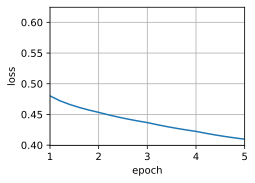

In [35]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 15.4.3. Applying Word Embeddings

In [36]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype("int32")
    for i in topk[1:]:  # Remove the input words
        print(f"cosine sim={float(cos[i]):.3f}: {vocab.to_tokens(i)}")


get_similar_tokens("chip", 3, net[0])

cosine sim=0.705: intel
cosine sim=0.640: mainframes
cosine sim=0.604: microprocessor


# 15.5. Word Embedding with Global Vectors (GloVe)

- Denoting by $q_{ij}$ the conditional probability $P(w_j\mid w_i)$ of word $w_j$ given word $w_i$ in the skip-gram model, we have
$$q_{ij}=\frac{\exp(\mathbf{u}_j^\top \mathbf{v}_i)}{ \sum_{k \in \mathcal{V}} \exp(\mathbf{u}_k^\top \mathbf{v}_i)},$$
 
where for any index i vectors $\mathbf{v}_i$ and $\mathbf{u}_i$ represent word $w_i$ as the center word and context word, respectively, and $\mathcal{V} = \{0, 1, \ldots, |\mathcal{V}|-1\}$ is the index set of the vocabulary.
- Now let’s denote the multiplicity of element j in multiset $\mathcal{C}_i$ as $x_{ij}$. This is the global co-occurrence count of word 
 (as the context word) and word $w_j$ (as the center word) in the same context window in the entire corpus. Using such global corpus statistics, the loss function of the skip-gram model is equivalent to
$$-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}} x_{ij} \log\,q_{ij}.$$
- We further denote by $x_i$ the number of all the context words in the context windows where $w_i$ occurs as their center word, which is equivalent to $|\mathcal{C}_i|$. Letting $p_{ij}$ be the conditional probability $x_{ij}/x_i$ for generating context word $w_j$ given center word $w_i$, (15.5.2) can be rewritten as
$$-\sum_{i\in\mathcal{V}} x_i \sum_{j\in\mathcal{V}} p_{ij} \log\,q_{ij}.$$


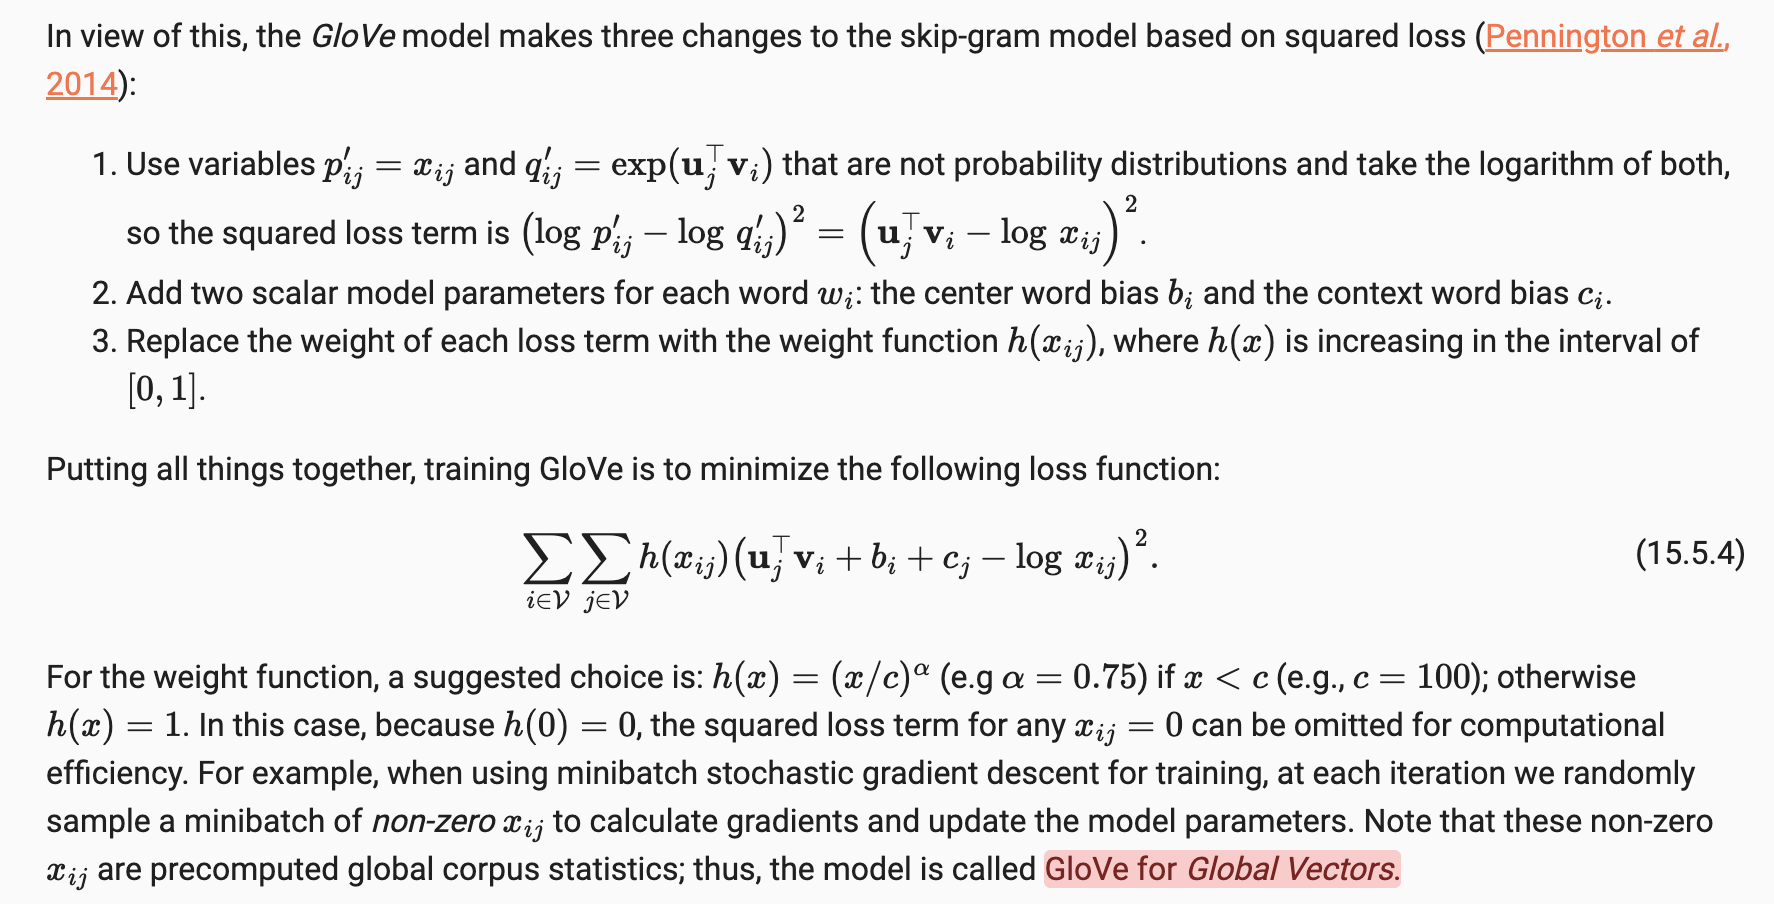

# 15.6. Subword Embedding

In fastText, for any word w, denote by $\mathcal{G}_w$ the union of all its subwords of length between 3 and 6 and its special subword. The vocabulary is the union of the subwords of all words. Letting $\mathbf{z}_g$ be the vector of subword g in the dictionary, the vector $\mathbf{v}_w$ for word w as a center word in the skip-gram model is the sum of its subword vectors:
$$\mathbf{v}_w = \sum_{g\in\mathcal{G}_w} \mathbf{z}_g.$$
The rest of fastText is the same as the skip-gram model.

## 15.6.2. Byte Pair Encoding

Byte pair encoding performs a statistical analysis of the training dataset to discover common symbols within a word, such as consecutive characters of arbitrary length. Starting from symbols of length 1, byte pair encoding iteratively merges the most frequent pair of consecutive symbols to produce new longer symbols. Note that for efficiency, pairs crossing word boundaries are not considered

In [37]:
symbols = [
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",
    "_",
    "[UNK]",
]

In [38]:
raw_token_freqs = {"fast_": 4, "faster_": 3, "tall_": 5, "taller_": 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[" ".join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

In [ ]:
def get_max_freq_pair(token_freqs):
    """returns the most frequent pair of consecutive symbols within a word, where words come from keys of the input dictionary token_freqs"""
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # Key of `pairs` is a tuple of two consecutive symbols
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  # Key of `pairs` with the max value

In [ ]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    """merge the most frequent pair of consecutive symbols to produce new symbols"""
    symbols.append("".join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(" ".join(max_freq_pair), "".join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

In [41]:
num_merges = 10
for i in range(num_merges):
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f"merge #{i + 1}:", max_freq_pair)

merge #1: ('t', 'a')
merge #2: ('ta', 'l')
merge #3: ('tal', 'l')
merge #4: ('f', 'a')
merge #5: ('fa', 's')
merge #6: ('fas', 't')
merge #7: ('e', 'r')
merge #8: ('er', '_')
merge #9: ('tall', '_')
merge #10: ('fast', '_')


In [42]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


In [43]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


In [ ]:
def segment_BPE(tokens, symbols):
    """break words into the longest possible subwords from the input argument symbols"""
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # Segment token with the longest possible subwords from symbols
        while start < len(token) and start < end:
            if token[start:end] in symbols:
                cur_output.append(token[start:end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append("[UNK]")
        outputs.append(" ".join(cur_output))
    return outputs

In [45]:
tokens = ["tallest_", "fatter_"]
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


# 15.7. Word Similarity and Analogy

## 15.7.1. Loading Pretrained Word Vectors

In [47]:
# @save
d2l.DATA_HUB["glove.6b.50d"] = (
    d2l.DATA_URL + "glove.6B.50d.zip",
    "0b8703943ccdb6eb788e6f091b8946e82231bc4d",
)

# @save
d2l.DATA_HUB["glove.6b.100d"] = (
    d2l.DATA_URL + "glove.6B.100d.zip",
    "cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a",
)

# @save
d2l.DATA_HUB["glove.42b.300d"] = (
    d2l.DATA_URL + "glove.42B.300d.zip",
    "b5116e234e9eb9076672cfeabf5469f3eec904fa",
)

# @save
d2l.DATA_HUB["wiki.en"] = (
    d2l.DATA_URL + "wiki.en.zip",
    "c1816da3821ae9f43899be655002f6c723e91b88",
)

In [48]:
# @save
class TokenEmbedding:
    """Token Embedding."""

    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ["<unk>"], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, "vec.txt"), "r") as f:
            for line in f:
                elems = line.rstrip().split(" ")
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx) for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [49]:
glove_6b50d = TokenEmbedding("glove.6b.50d")

In [50]:
len(glove_6b50d)

400001

In [51]:
glove_6b50d.token_to_idx["beautiful"], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

## 15.7.2. Applying Pretrained Word Vectors

### 15.7.2.1. Word Similarity

In [52]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(
        W,
        x.reshape(
            -1,
        ),
    ) / (torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) * torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

In [53]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f"cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}")

In [54]:
get_similar_tokens("chip", 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [55]:
get_similar_tokens("baby", 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


In [56]:
get_similar_tokens("beautiful", 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


### 15.7.2.2. Word Analogy

In [57]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

In [58]:
get_analogy("man", "woman", "son", glove_6b50d)

'daughter'

In [59]:
get_analogy("beijing", "china", "tokyo", glove_6b50d)

'japan'

In [60]:
get_analogy("bad", "worst", "big", glove_6b50d)

'biggest'

In [61]:
get_analogy("do", "did", "go", glove_6b50d)

'went'

# 15.8. Bidirectional Encoder Representations from Transformers (BERT)

all word embedding models are all context-independent

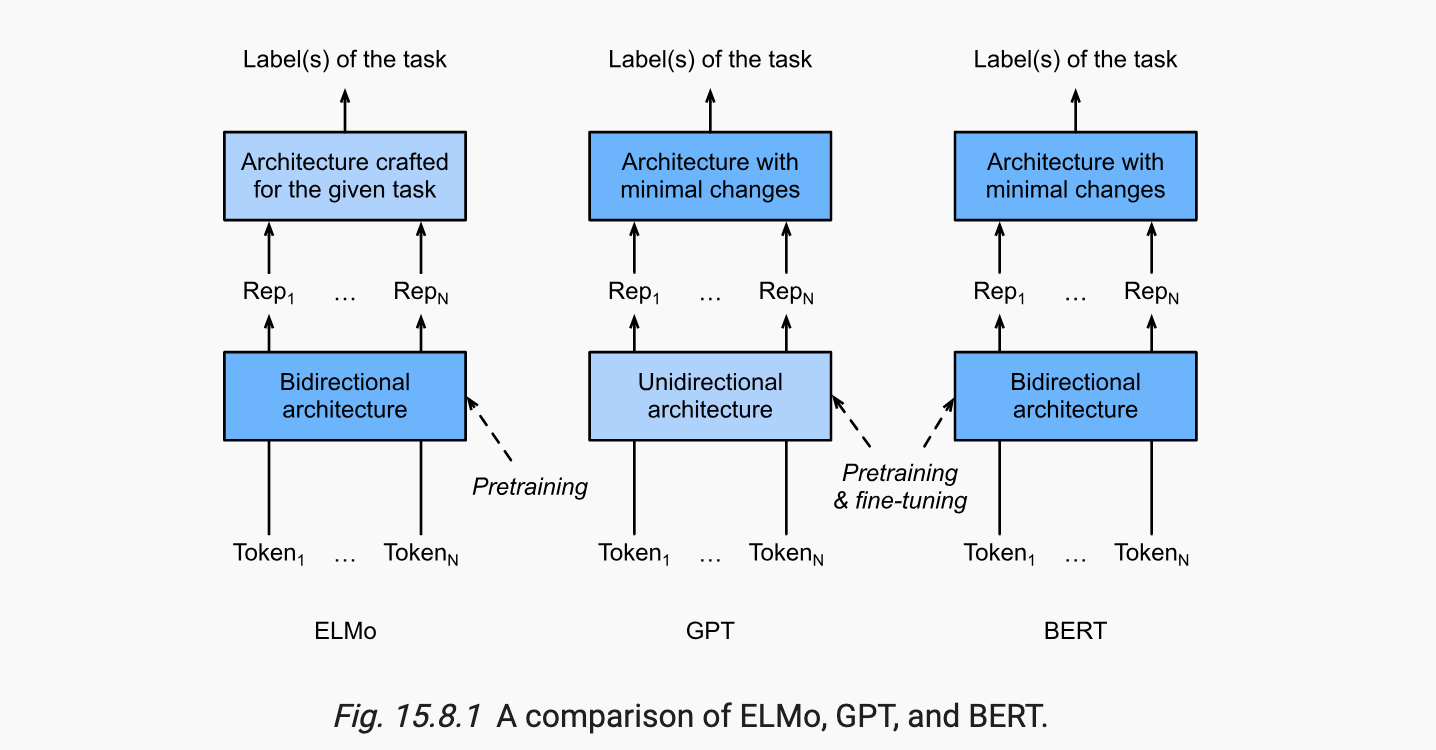

## 15.8.4. Input Representation

In [62]:
# @save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ["<cls>"] + tokens_a + ["<sep>"]
    # 0 and 1 are marking segment A and B, respectively
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ["<sep>"]
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

- BERT chooses the Transformer encoder as its bidirectional architecture
- BERT uses learnable positional embeddings
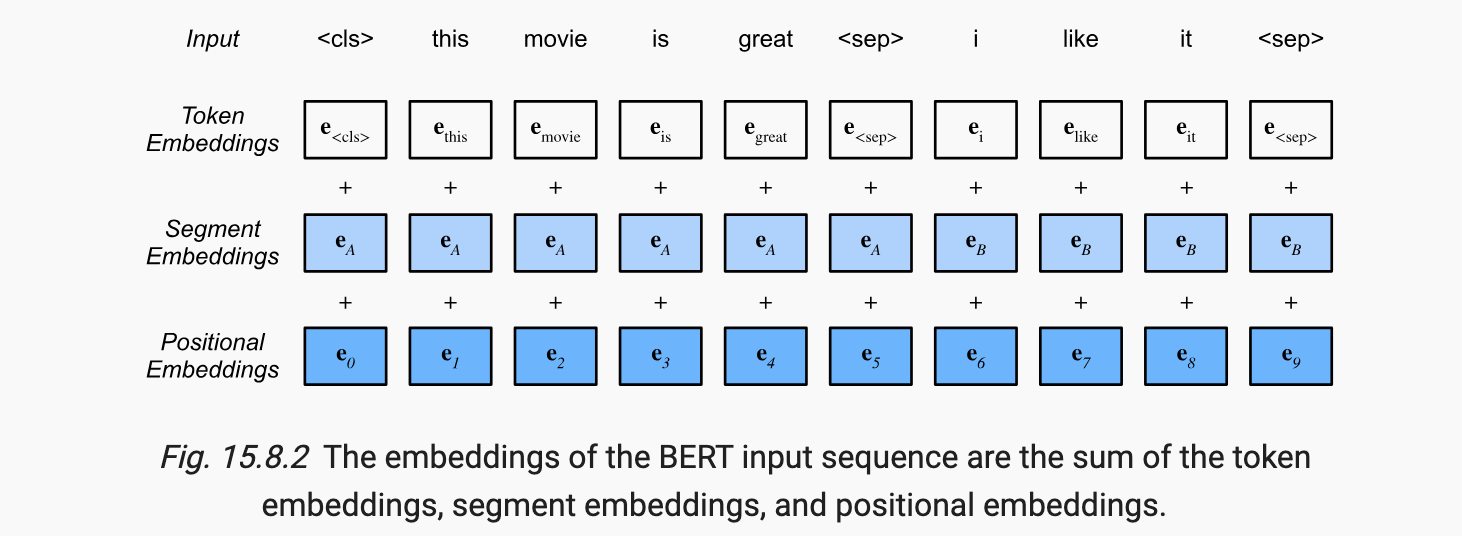

In [ ]:
# @save
class BERTEncoder(nn.Module):
    """
    BERTEncoder uses segment embeddings and learnable positional embeddings
    """

    def __init__(
        self,
        vocab_size,
        num_hiddens,
        ffn_num_hiddens,
        num_heads,
        num_blks,
        dropout,
        max_len=1000,
        **kwargs,
    ):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)
        self.segment_embedding = nn.Embedding(2, num_hiddens)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(
                f"{i}",
                d2l.TransformerEncoderBlock(
                    num_hiddens, ffn_num_hiddens, num_heads, dropout, True
                ),
            )
        # In BERT, positional embeddings are learnable, thus we create a
        # parameter of positional embeddings that are long enough
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens))

    def forward(self, tokens, segments, valid_lens):
        # Shape of `X` remains unchanged in the following code snippet:
        # (batch size, max sequence length, `num_hiddens`)
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding[:, : X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

In [65]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
ffn_num_input, num_blks, dropout = 768, 2, 0.2
encoder = BERTEncoder(
    vocab_size, num_hiddens, ffn_num_hiddens, num_heads, num_blks, dropout
)

In [66]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## 15.8.5. Pretraining Tasks

### 15.8.5.1. Masked Language Modeling

However, the artificial special token “\<mask\>” will never appear in fine-tuning. To avoid such a mismatch between pretraining and fine-tuning, if a token is masked for prediction (e.g., “great” is selected to be masked and predicted in “this movie is great”), in the input it will be replaced with:
- a special “\<mask\>” token for 80% of the time (e.g., “this movie is great” becomes “this movie is \<mask\>”);
- a random token for 10% of the time (e.g., “this movie is great” becomes “this movie is drink”);
- the unchanged label token for 10% of the time (e.g., “this movie is great” becomes “this movie is great”).

In [67]:
# @save
class MaskLM(nn.Module):
    """The masked language model task of BERT."""

    def __init__(self, vocab_size, num_hiddens, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        self.mlp = nn.Sequential(
            nn.LazyLinear(num_hiddens),
            nn.ReLU(),
            nn.LayerNorm(num_hiddens),
            nn.LazyLinear(vocab_size),
        )

    def forward(self, X, pred_positions):
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        # Suppose that `batch_size` = 2, `num_pred_positions` = 3, then
        # `batch_idx` is `torch.tensor([0, 0, 0, 1, 1, 1])`
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

In [68]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

In [69]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction="none")
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape

torch.Size([6])

### 15.8.5.2. Next Sentence Prediction

In [70]:
# @save
class NextSentencePred(nn.Module):
    """The next sentence prediction task of BERT."""

    def __init__(self, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.LazyLinear(2)

    def forward(self, X):
        # `X` shape: (batch size, `num_hiddens`)
        return self.output(X)

In [71]:
# PyTorch by default will not flatten the tensor as seen in mxnet where, if
# flatten=True, all but the first axis of input data are collapsed together
encoded_X = torch.flatten(encoded_X, start_dim=1)
# input_shape for NSP: (batch size, `num_hiddens`)
nsp = NextSentencePred()
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [72]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

## 15.8.6. Putting It All Together

In [73]:
# @save
class BERTModel(nn.Module):
    """The BERT model."""

    def __init__(
        self,
        vocab_size,
        num_hiddens,
        ffn_num_hiddens,
        num_heads,
        num_blks,
        dropout,
        max_len=1000,
    ):
        super(BERTModel, self).__init__()
        self.encoder = BERTEncoder(
            vocab_size,
            num_hiddens,
            ffn_num_hiddens,
            num_heads,
            num_blks,
            dropout,
            max_len=max_len,
        )
        self.hidden = nn.Sequential(nn.LazyLinear(num_hiddens), nn.Tanh())
        self.mlm = MaskLM(vocab_size, num_hiddens)
        self.nsp = NextSentencePred()

    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens)
        if pred_positions is not None:
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else:
            mlm_Y_hat = None
        # The hidden layer of the MLP classifier for next sentence prediction.
        # 0 is the index of the '<cls>' token
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :]))
        return encoded_X, mlm_Y_hat, nsp_Y_hat

# 15.9. The Dataset for Pretraining BERT

In [74]:
# @save
d2l.DATA_HUB["wikitext-2"] = (
    "https://s3.amazonaws.com/research.metamind.io/wikitext/" "wikitext-2-v1.zip",
    "3c914d17d80b1459be871a5039ac23e752a53cbe",
)


# @save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, "wiki.train.tokens")
    with open(file_name, "r") as f:
        lines = f.readlines()
    # Uppercase letters are converted to lowercase ones
    paragraphs = [
        line.strip().lower().split(" . ")
        for line in lines
        if len(line.split(" . ")) >= 2
    ]
    random.shuffle(paragraphs)
    return paragraphs

## 15.9.1. Defining Helper Functions for Pretraining Tasks

In [75]:
# @save
def _get_next_sentence(sentence, next_sentence, paragraphs):
    if random.random() < 0.5:
        is_next = True
    else:
        # `paragraphs` is a list of lists of lists
        next_sentence = random.choice(random.choice(paragraphs))
        is_next = False
    return sentence, next_sentence, is_next

In [76]:
# @save
def _get_nsp_data_from_paragraph(paragraph, paragraphs, vocab, max_len):
    nsp_data_from_paragraph = []
    for i in range(len(paragraph) - 1):
        tokens_a, tokens_b, is_next = _get_next_sentence(
            paragraph[i], paragraph[i + 1], paragraphs
        )
        # Consider 1 '<cls>' token and 2 '<sep>' tokens
        if len(tokens_a) + len(tokens_b) + 3 > max_len:
            continue
        tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
        nsp_data_from_paragraph.append((tokens, segments, is_next))
    return nsp_data_from_paragraph

In [77]:
# @save
def _replace_mlm_tokens(tokens, candidate_pred_positions, num_mlm_preds, vocab):
    # For the input of a masked language model, make a new copy of tokens and
    # replace some of them by '<mask>' or random tokens
    mlm_input_tokens = [token for token in tokens]
    pred_positions_and_labels = []
    # Shuffle for getting 15% random tokens for prediction in the masked
    # language modeling task
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token = None
        # 80% of the time: replace the word with the '<mask>' token
        if random.random() < 0.8:
            masked_token = "<mask>"
        else:
            # 10% of the time: keep the word unchanged
            if random.random() < 0.5:
                masked_token = tokens[mlm_pred_position]
            # 10% of the time: replace the word with a random word
            else:
                masked_token = random.choice(vocab.idx_to_token)
        mlm_input_tokens[mlm_pred_position] = masked_token
        pred_positions_and_labels.append((mlm_pred_position, tokens[mlm_pred_position]))
    return mlm_input_tokens, pred_positions_and_labels

In [78]:
# @save
def _get_mlm_data_from_tokens(tokens, vocab):
    candidate_pred_positions = []
    # `tokens` is a list of strings
    for i, token in enumerate(tokens):
        # Special tokens are not predicted in the masked language modeling
        # task
        if token in ["<cls>", "<sep>"]:
            continue
        candidate_pred_positions.append(i)
    # 15% of random tokens are predicted in the masked language modeling task
    num_mlm_preds = max(1, round(len(tokens) * 0.15))
    mlm_input_tokens, pred_positions_and_labels = _replace_mlm_tokens(
        tokens, candidate_pred_positions, num_mlm_preds, vocab
    )
    pred_positions_and_labels = sorted(pred_positions_and_labels, key=lambda x: x[0])
    pred_positions = [v[0] for v in pred_positions_and_labels]
    mlm_pred_labels = [v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens], pred_positions, vocab[mlm_pred_labels]

## 15.9.2. Transforming Text into the Pretraining Dataset

In [79]:
# @save
def _pad_bert_inputs(examples, max_len, vocab):
    max_num_mlm_preds = round(max_len * 0.15)
    (
        all_token_ids,
        all_segments,
        valid_lens,
    ) = (
        [],
        [],
        [],
    )
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    for token_ids, pred_positions, mlm_pred_label_ids, segments, is_next in examples:
        all_token_ids.append(
            torch.tensor(
                token_ids + [vocab["<pad>"]] * (max_len - len(token_ids)),
                dtype=torch.long,
            )
        )
        all_segments.append(
            torch.tensor(segments + [0] * (max_len - len(segments)), dtype=torch.long)
        )
        # `valid_lens` excludes count of '<pad>' tokens
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(
            torch.tensor(
                pred_positions + [0] * (max_num_mlm_preds - len(pred_positions)),
                dtype=torch.long,
            )
        )
        # Predictions of padded tokens will be filtered out in the loss via
        # multiplication of 0 weights
        all_mlm_weights.append(
            torch.tensor(
                [1.0] * len(mlm_pred_label_ids)
                + [0.0] * (max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32,
            )
        )
        all_mlm_labels.append(
            torch.tensor(
                mlm_pred_label_ids
                + [0] * (max_num_mlm_preds - len(mlm_pred_label_ids)),
                dtype=torch.long,
            )
        )
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (
        all_token_ids,
        all_segments,
        valid_lens,
        all_pred_positions,
        all_mlm_weights,
        all_mlm_labels,
        nsp_labels,
    )

In [80]:
# @save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # Input `paragraphs[i]` is a list of sentence strings representing a
        # paragraph; while output `paragraphs[i]` is a list of sentences
        # representing a paragraph, where each sentence is a list of tokens
        paragraphs = [d2l.tokenize(paragraph, token="word") for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs for sentence in paragraph]
        self.vocab = d2l.Vocab(
            sentences, min_freq=5, reserved_tokens=["<pad>", "<mask>", "<cls>", "<sep>"]
        )
        # Get data for the next sentence prediction task
        examples = []
        for paragraph in paragraphs:
            examples.extend(
                _get_nsp_data_from_paragraph(paragraph, paragraphs, self.vocab, max_len)
            )
        # Get data for the masked language model task
        examples = [
            (_get_mlm_data_from_tokens(tokens, self.vocab) + (segments, is_next))
            for tokens, segments, is_next in examples
        ]
        # Pad inputs
        (
            self.all_token_ids,
            self.all_segments,
            self.valid_lens,
            self.all_pred_positions,
            self.all_mlm_weights,
            self.all_mlm_labels,
            self.nsp_labels,
        ) = _pad_bert_inputs(examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (
            self.all_token_ids[idx],
            self.all_segments[idx],
            self.valid_lens[idx],
            self.all_pred_positions[idx],
            self.all_mlm_weights[idx],
            self.all_mlm_labels[idx],
            self.nsp_labels[idx],
        )

    def __len__(self):
        return len(self.all_token_ids)

In [116]:
# @save
def load_data_wiki(batch_size, max_len):
    """Load the WikiText-2 dataset."""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract("wikitext-2", "wikitext-2")
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(
        train_set, batch_size, shuffle=True, num_workers=num_workers
    )
    return train_iter, train_set.vocab

In [115]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (
    tokens_X,
    segments_X,
    valid_lens_x,
    pred_positions_X,
    mlm_weights_X,
    mlm_Y,
    nsp_y,
) in train_iter:
    print(
        tokens_X.shape,
        segments_X.shape,
        valid_lens_x.shape,
        pred_positions_X.shape,
        mlm_weights_X.shape,
        mlm_Y.shape,
        nsp_y.shape,
    )
    break

BadZipFile: File is not a zip file

the zip file does not exist!

In [83]:
len(vocab)

6719

# 15.10. Pretraining BERT

The base model ($\textrm{BERT}_{\textrm{BASE}}$) uses 12 layers (Transformer encoder blocks) with 768 hidden units (hidden size) and 12 self-attention heads. The large model ($\textrm{BERT}_{\textrm{LARGE}}$) uses 24 layers with 1024 hidden units and 16 self-attention heads

## 15.10.1. Pretraining BERT

In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

In [107]:
net = d2l.BERTModel(
    len(vocab),
    num_hiddens=128,
    ffn_num_hiddens=256,
    num_heads=2,
    num_blks=2,
    dropout=0.2,
)
devices = d2l.try_all_gpus()
loss = nn.CrossEntropyLoss()

In [108]:
# @save
def _get_batch_loss_bert(
    net,
    loss,
    vocab_size,
    tokens_X,
    segments_X,
    valid_lens_x,
    pred_positions_X,
    mlm_weights_X,
    mlm_Y,
    nsp_y,
):
    # Forward pass
    _, mlm_Y_hat, nsp_Y_hat = net(
        tokens_X, segments_X, valid_lens_x.reshape(-1), pred_positions_X
    )
    # Compute masked language model loss
    mlm_l = loss(
        mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)
    ) * mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # Compute next sentence prediction loss
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

In [109]:
def train_bert(train_iter, net, loss, vocab_size, devices, num_steps):
    net(*next(iter(train_iter))[:4])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    trainer = torch.optim.Adam(net.parameters(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(
        xlabel="step", ylabel="loss", xlim=[1, num_steps], legend=["mlm", "nsp"]
    )
    # Sum of masked language modeling losses, sum of next sentence prediction
    # losses, no. of sentence pairs, count
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    while step < num_steps and not num_steps_reached:
        for (
            tokens_X,
            segments_X,
            valid_lens_x,
            pred_positions_X,
            mlm_weights_X,
            mlm_Y,
            nsp_y,
        ) in train_iter:
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad()
            timer.start()
            mlm_l, nsp_l, l = _get_batch_loss_bert(
                net,
                loss,
                vocab_size,
                tokens_X,
                segments_X,
                valid_lens_x,
                pred_positions_X,
                mlm_weights_X,
                mlm_Y,
                nsp_y,
            )
            l.backward()
            trainer.step()
            metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
            timer.stop()
            animator.add(step + 1, (metric[0] / metric[3], metric[1] / metric[3]))
            step += 1
            if step == num_steps:
                num_steps_reached = True
                break

    print(
        f"MLM loss {metric[0] / metric[3]:.3f}, "
        f"NSP loss {metric[1] / metric[3]:.3f}"
    )
    print(f"{metric[2] / timer.sum():.1f} sentence pairs/sec on " f"{str(devices)}")

In [ ]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## 15.10.2. Representing Text with BERT

In [111]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

In [ ]:
tokens_a = ["a", "crane", "is", "flying"]
encoded_text = get_bert_encoding(net, tokens_a)
# Tokens: '<cls>', 'a', 'crane', 'is', 'flying', '<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

In [ ]:
tokens_a, tokens_b = ["a", "crane", "driver", "came"], ["he", "just", "left"]
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# Tokens: '<cls>', 'a', 'crane', 'driver', 'came', '<sep>', 'he', 'just',
# 'left', '<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]